## Imports

In [1]:
import datetime

import matplotlib.pyplot as plt
import holidays
import numpy as np

import lightgbm as lgb
import pandas as pd
import polars as pl
import pathlib
import mlflow
from sklearn.model_selection import TimeSeriesSplit

## Environment variables

In [2]:
DEBUG = False

In [3]:
import random
def set_seed(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    pl.set_random_seed(seed)

SEED = 42
set_seed(seed=SEED)

## Constants definition

### Paths

In [4]:
BASE_DATA_PATH: pathlib.Path = pathlib.Path().absolute().parent.parent / 'data' / 'predict-energy-behavior-of-prosumers'

CLIENTS_PATH: pathlib.Path = BASE_DATA_PATH / 'client.csv'
ELECTRICITY_PATH: pathlib.Path = BASE_DATA_PATH / 'electricity_prices.csv'
GAS_PATH: pathlib.Path = BASE_DATA_PATH / 'gas_prices.csv'
HISTORICAL_WEATHER_PATH: pathlib.Path = BASE_DATA_PATH / 'historical_weather.csv'
WEATHER_FORECAST_PATH: pathlib.Path = BASE_DATA_PATH / 'forecast_weather.csv'
TRAIN_PATH: pathlib.Path = BASE_DATA_PATH / 'train.csv'
WEATHER_STATION_COUNTY_PATH: pathlib.Path = BASE_DATA_PATH / 'weather_station_to_county_mapping.csv'
COUNTY_MAP_PATH: pathlib.Path = BASE_DATA_PATH / "county_id_to_name_map.json"

### Constants

In [5]:
DATE_FORMAT: str = '%Y-%m-%d'
DATETIME_FORMAT: str = '%Y-%m-%d %H:%M:%S'
TIMEZONE: str = "Europe/Tallinn"
ESTONIAN_HOLIDAYS = list(
    holidays.country_holidays("EE", years=range(2021, 2026)).keys()
)

## Helper functions

In [6]:
def assert_null_counts(dataframe: pl.LazyFrame) -> bool:
    if not DEBUG:
        return False
    length_dataframe: int = dataframe.collect().shape[0]
    
    return np.any(dataframe.null_count().with_columns(
        *[pl.col(col) == length_dataframe for col in dataframe.columns]
    ).collect().to_numpy())

## Data load

## Load client and convert columns

In [7]:
clients: pl.LazyFrame = pl.scan_csv(CLIENTS_PATH)
clients = clients.with_columns(
    [
        pl.col("product_type").cast(pl.Int8),
        pl.col("county").cast(pl.Int8),
        pl.col("eic_count").cast(pl.Int16),
        pl.col("installed_capacity").cast(pl.Float32),
        pl.col("is_business").cast(pl.Int8),
        pl.col("date").str.to_date(DATE_FORMAT),
        pl.col("data_block_id").cast(pl.Int16)
    ]
)
assert assert_null_counts(clients) == False

## Load electricity prices and convert columns

In [8]:
electricity: pl.LazyFrame = pl.scan_csv(ELECTRICITY_PATH).drop(["origin_date"])
electricity = electricity.with_columns(
    [
        pl.col("forecast_date").str.to_datetime(DATETIME_FORMAT) + pl.duration(days=1),
        pl.col("euros_per_mwh").cast(pl.Float32),
        pl.col("data_block_id").cast(pl.Int16)
    ]
).rename({"forecast_date": "datetime", "euros_per_mwh": "electricity_euros_per_mwh"})
# electricity.sort(["data_block_id", "datetime"]).select("data_block_id", "datetime").collect()
assert assert_null_counts(electricity) == False

## Load gas prices and convert columns

In [9]:
gas: pl.LazyFrame = pl.scan_csv(GAS_PATH).drop(["origin_date"])
gas = gas.with_columns(
    [
        pl.col("forecast_date").str.to_date(DATE_FORMAT),
        pl.col("lowest_price_per_mwh").cast(pl.Float32),
        pl.col("highest_price_per_mwh").cast(pl.Float32),
        ((pl.col("lowest_price_per_mwh") + pl.col("highest_price_per_mwh")) / 2).alias("gas_mean_price_per_mhw"),
        pl.col("data_block_id").cast(pl.Int16)
    ]
).rename({"forecast_date": "date", "lowest_price_per_mwh": "gas_lowest_price_per_mwh", "highest_price_per_mwh": "gas_highest_price_per_mwh"})
# gas.sort(["data_block_id", "date"]).head(5).collect()
assert assert_null_counts(gas) == False

## Load weather-county mapping and convet columns

In [10]:
weather_station_county_mapping: pl.LazyFrame = pl.scan_csv(WEATHER_STATION_COUNTY_PATH)
weather_station_county_mapping = weather_station_county_mapping.with_columns([
    pl.col("longitude").cast(pl.Float32).round(decimals=2),
    pl.col("latitude").cast(pl.Float32).round(decimals=2),
    pl.col("county").cast(pl.Int8).fill_null(-1),
    pl.col("county_name").fill_null("Unknown")
])

weather_station_county_mapping = weather_station_county_mapping.join(other=weather_station_county_mapping.group_by("county").agg([
    pl.col("longitude").min().alias("longitude_min"),
    pl.col("longitude").max().alias("longitude_max"),
    pl.col("latitude").min().alias("latitude_min"),
    pl.col("latitude").max().alias("latitude_max"),
]),
    on=["county"],
    how="inner"
)

# weather_station_county_mapping.collect()
assert assert_null_counts(weather_station_county_mapping) == False

## Load weather forecast and convert columns

In [11]:
weather_forecast: pl.LazyFrame = pl.scan_csv(WEATHER_FORECAST_PATH).drop(["origin_datetime"]).rename({"forecast_datetime": "datetime"})
# weather_forecast = weather_forecast.filter(pl.col("hours_ahead") >= 24)  # we don't need to forecast for today
weather_forecast = weather_forecast.with_columns(
    [
        pl.col("datetime").str.to_datetime(DATETIME_FORMAT),
        pl.col("latitude").cast(pl.Float32).round(decimals=2),
        pl.col("longitude").cast(pl.Float32).round(decimals=2),
        pl.col("data_block_id").cast(pl.Int16),
    ]
)

weather_forecast = weather_forecast.join(
    other=weather_station_county_mapping,
    how="left",
    on=["latitude", "longitude"]
).drop(["latitude", "longitude"])

weather_forecast_mean = weather_forecast.group_by("county", "datetime", "data_block_id").agg(
        pl.col("hours_ahead").mean(),
        pl.col("temperature").mean(),
        pl.col("dewpoint").mean(),
        pl.col("cloudcover_high").mean(),
        pl.col("cloudcover_low").mean(),
        pl.col("cloudcover_mid").mean(),
        pl.col("cloudcover_total").mean(),
        pl.col("10_metre_u_wind_component").mean(),
        pl.col("10_metre_v_wind_component").mean(),
        pl.col("direct_solar_radiation").mean(),
        pl.col("surface_solar_radiation_downwards").mean(),
        pl.col("snowfall").mean(),
        pl.col("total_precipitation").mean(),
        pl.col("latitude_min").first(),
        pl.col("latitude_max").first(),
        pl.col("longitude_min").first(),
        pl.col("longitude_max").first(),
        pl.col("county_name").first(),
)

# weather_forecast_mean.sort("county", "datetime", "data_block_id").head().collect()
assert assert_null_counts(weather_forecast_mean) == False

## Load historical weather and convert columns

In [12]:
historical_weather: pl.LazyFrame = pl.scan_csv(HISTORICAL_WEATHER_PATH)
historical_weather = historical_weather.with_columns(
    [
        pl.col("datetime").str.to_datetime(DATETIME_FORMAT),
        pl.col("latitude").cast(pl.Float32).round(decimals=2),
        pl.col("longitude").cast(pl.Float32).round(decimals=2),
        pl.col("data_block_id").cast(pl.Int16)
    ]
)

historical_weather = historical_weather.join(
    other=weather_station_county_mapping,
    how="left",
    on=["latitude", "longitude"]
).drop(["latitude", "longitude"])

old_columns = historical_weather.columns
historical_weather_mean = historical_weather.group_by("county", "datetime", "data_block_id").agg(
    pl.col("temperature").mean(),
    pl.col("dewpoint").mean(),
    pl.col("rain").mean(),
    pl.col("snowfall").mean(),
    pl.col("surface_pressure").mean(),
    pl.col("cloudcover_total").mean(),
    pl.col("cloudcover_low").mean(),
    pl.col("cloudcover_mid").mean(),
    pl.col("cloudcover_high").mean(),
    pl.col("windspeed_10m").mean(),
    pl.col("winddirection_10m").mean(),
    pl.col("shortwave_radiation").mean(),
    pl.col("direct_solar_radiation").mean(),
    pl.col("diffuse_radiation").mean(),
    pl.col("latitude_min").first(),
    pl.col("latitude_max").first(),
    pl.col("longitude_min").first(),
    pl.col("longitude_max").first(),
    pl.col("county_name").first(),
    )

# Test set has 1 day offset for hour<11 and 2 day offset for hour>11
historical_weather_mean = historical_weather_mean.with_columns(
    pl.when(pl.col("datetime").dt.hour() < 11).then(pl.col("datetime") + pl.duration(days=1)).otherwise(pl.col("datetime") + pl.duration(days=2))
)

# historical_weather_mean = historical_weather_mean.rename({column: f"historical_{column}" for column in historical_weather_mean.columns})

assert assert_null_counts(historical_weather_mean) == False
# historical_weather_mean.sort("data_block_id", "datetime", "county").head().collect()

## Load Train and convert columns

In [13]:
train: pl.LazyFrame = pl.scan_csv(TRAIN_PATH)

train = train.drop(["prediction_unit_id", "row_id"]).with_columns(
        pl.col("datetime").str.to_datetime(DATETIME_FORMAT),
        pl.col("is_business").cast(pl.Int8),
        pl.col("product_type").cast(pl.Int8),
        pl.col("target").cast(pl.Float32),
        pl.col("is_consumption").cast(pl.Int8),
        pl.col("county").cast(pl.Int8),
        pl.col("data_block_id").cast(pl.Int16),
)
train = train.with_columns(
        pl.col("datetime").dt.year().alias("year"),
        pl.col("datetime").cast(pl.Date).alias("date"),
        pl.col("datetime").dt.month().alias("month"),
        pl.col("datetime").dt.weekday().alias("weekday"),
        pl.col("datetime").dt.day().alias("day"),
        pl.col("datetime").dt.ordinal_day().alias("day_of_year"),
        pl.col("datetime").dt.hour().alias("hour")
)

assert assert_null_counts(train) == False

## Data shapes

In [14]:
clients_shape: int = clients.select("is_business").collect().shape[0]
electricity_shape: int = electricity.select("datetime").collect().shape[0]
gas_shape: int = gas.select("date").collect().shape[0]
weather_forecast_shape: int = weather_forecast.select("datetime").collect().shape[0]
historical_weather_shape: int = historical_weather.select("datetime").collect().shape[0]
train_shape: int = train.select("datetime").collect().shape[0]

print(f"Number of training data\nClient: {clients_shape}\nEnergy: {electricity_shape}\nGas: {gas_shape}\nWeather forecast: {weather_forecast_shape}\nHistorical weather: {historical_weather_shape}\nTrain: {train_shape}")

Number of training data
Client: 41919
Energy: 15286
Gas: 637
Weather forecast: 3424512
Historical weather: 1710802
Train: 2018352


## Data merge (be careful on dates and times)

### Merge train and clients

In [15]:
merged: pl.LazyFrame = (train
                        .join(other=clients, how="left", on=["county", "is_business", "product_type", "data_block_id"], suffix="_client")
                        .join(other=gas, on="data_block_id", how="left", suffix="_gas")
                        .join(other=electricity, on=["datetime", "data_block_id"], how="left", suffix="_electricity")
                        )


assert merged.collect().shape[0] == train_shape
assert assert_null_counts(merged) == False

#### Check merged rows when gas is not null

In [16]:
# merged.sort(["county", "is_business", "product_type", "data_block_id", "datetime"]).filter(pl.col("date_gas").is_not_null()).head().collect()

#### Check merged rows when client is not null

In [17]:
# merged.sort(["county", "is_business", "product_type", "data_block_id", "datetime"]).filter(pl.col("date_client").is_not_null()).head().collect()

#### Check merged rows when electricity is not null

In [18]:
# merged.sort(["county", "is_business", "product_type", "data_block_id", "datetime"]).filter(pl.col("electricity_euros_per_mwh").is_not_nan()).head().collect()

### Add client id

In [19]:
client_ids_columns = ["county", "is_business", "product_type", "is_consumption"]

merged = merged.group_by(client_ids_columns).len().drop("len").sort(client_ids_columns).with_row_index(name="client_id").join(
    other=merged,
    how="inner",
    on=["county", "is_business", "product_type", "is_consumption"]
)
assert merged.collect().shape[0] == train_shape
assert assert_null_counts(merged) == False

### Join with historical weather

In [20]:
merged = merged.join(other=historical_weather_mean, how="left", on=["county", "datetime", "data_block_id"], suffix="_measured")
assert merged.collect().shape[0] == train_shape
assert assert_null_counts(merged) == False

### Join with weather forecast

In [21]:
merged = merged.join(other=weather_forecast_mean, how="left", on=["county", "datetime", "data_block_id"], suffix="_forecast")
assert merged.collect().shape[0] == train_shape
assert assert_null_counts(merged) == False

### Create lagged weather features

In [22]:
lagged_weather_forecast = weather_forecast_mean.sort("county", "datetime", "data_block_id").rolling(index_column="datetime", period=f"1d", by=["county", "data_block_id"]).agg(
    [
        pl.col("temperature").mean().alias("temperature_forecast_last_day"),
        pl.col("dewpoint").mean().alias("dewpoint_forecast_last_day"),
        pl.col("snowfall").mean().alias("snowfall_forecast_last_day"),
        pl.col("cloudcover_total").mean().alias("cloudcover_total_forecast_last_day"),
        pl.col("cloudcover_low").mean().alias("cloudcover_low_forecast_last_day"),
        pl.col("cloudcover_mid").mean().alias("cloudcover_mid_forecast_last_day"),
        pl.col("cloudcover_high").mean().alias("cloudcover_high_forecast_last_day"),
        pl.col("10_metre_u_wind_component").mean().alias("10_metre_u_wind_component_forecast_last_day"),
        pl.col("10_metre_v_wind_component").mean().alias("10_metre_v_wind_component_forecast_last_day"),
        pl.col("surface_solar_radiation_downwards").mean().alias("surface_solar_radiation_downwards_forecast_last_day"),
        pl.col("direct_solar_radiation").mean().alias("direct_solar_radiation_forecast_last_day"),
        pl.col("total_precipitation").mean().alias("total_precipitation_forecast_last_day"),
    ]
)

assert assert_null_counts(lagged_weather_forecast) == False
lagged_weather_forecast.sort("county", "datetime").filter((pl.col("data_block_id") == 1)).collect()

county,data_block_id,datetime,temperature_forecast_last_day,dewpoint_forecast_last_day,snowfall_forecast_last_day,cloudcover_total_forecast_last_day,cloudcover_low_forecast_last_day,cloudcover_mid_forecast_last_day,cloudcover_high_forecast_last_day,10_metre_u_wind_component_forecast_last_day,10_metre_v_wind_component_forecast_last_day,surface_solar_radiation_downwards_forecast_last_day,direct_solar_radiation_forecast_last_day,total_precipitation_forecast_last_day
i8,i16,datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-1,1,2021-09-01 03:00:00,13.880225,11.300997,0.0,0.440289,0.121062,0.038372,0.350749,2.104932,-6.643793,0.0,0.0,0.0
-1,1,2021-09-01 04:00:00,13.863335,11.216695,0.0,0.440939,0.136749,0.056475,0.328278,2.227516,-6.765169,0.0,0.0,2.2931e-7
-1,1,2021-09-01 05:00:00,13.845042,11.139377,0.0,0.462066,0.143369,0.077927,0.334442,2.319997,-6.871741,0.0,0.0,3.8924e-7
-1,1,2021-09-01 06:00:00,13.844582,11.076452,0.0,0.484012,0.145801,0.083437,0.351921,2.385114,-6.934935,2.229814,11.785256,7.3968e-7
-1,1,2021-09-01 07:00:00,13.872556,11.015162,0.0,0.484483,0.14206,0.082439,0.357347,2.442779,-7.001381,17.12513,51.461619,8.7860e-7
-1,1,2021-09-01 08:00:00,13.916459,10.920488,0.0,0.48952,0.138288,0.078985,0.367431,2.500904,-7.110842,45.192583,107.36383,0.000002
-1,1,2021-09-01 09:00:00,13.976083,10.80247,0.0,0.502669,0.140406,0.077587,0.382354,2.574204,-7.19401,81.274193,160.675232,0.000004
-1,1,2021-09-01 10:00:00,14.047331,10.677116,0.0,0.514393,0.146407,0.077354,0.395513,2.685725,-7.230245,119.069872,201.93211,0.000005
-1,1,2021-09-01 11:00:00,14.123805,10.543495,0.0,0.525818,0.151911,0.082782,0.403064,2.84823,-7.265233,155.911173,235.631084,0.000008


In [23]:
lagged_historical_weather_week = historical_weather_mean.sort("county", "datetime", "data_block_id").rolling(index_column="datetime", period=f"1w", by=["county"]).agg(
    [
        pl.col("temperature").mean().alias("temperature_last_7_days"),
        pl.col("dewpoint").mean().alias("dewpoint_last_7_days"),
        pl.col("rain").mean().alias("rain_last_7_days"),
        pl.col("snowfall").mean().alias("snowfall_last_7_days"),
        pl.col("cloudcover_total").mean().alias("cloudcover_total_last_7_days"),
        pl.col("cloudcover_low").mean().alias("cloudcover_low_last_7_days"),
        pl.col("cloudcover_mid").mean().alias("cloudcover_mid_last_7_days"),
        pl.col("cloudcover_high").mean().alias("cloudcover_high_last_7_days"),
        pl.col("windspeed_10m").mean().alias("windspeed_10m_last_7_days"),
        pl.col("winddirection_10m").mean().alias("winddirection_10m_last_7_days"),
        pl.col("shortwave_radiation").mean().alias("shortwave_radiation_last_7_days"),
        pl.col("direct_solar_radiation").mean().alias("direct_solar_radiation_last_7_days"),
        pl.col("diffuse_radiation").mean().alias("diffuse_radiation_last_7_days"),
    ]
)


In [24]:
lagged_historical_weather_day = historical_weather_mean.with_columns(pl.col("datetime").dt.hour().alias("hour")).sort("county", "datetime").rolling(index_column="datetime", period=f"1d", by=["county"]).agg(
    [
        pl.col("temperature").mean().alias("temperature_last_24_hours"),
        pl.col("dewpoint").mean().alias("dewpoint_last_24_hours"),
        pl.col("rain").mean().alias("rain_last_24_hours"),
        pl.col("snowfall").mean().alias("snowfall_last_24_hours"),
        pl.col("cloudcover_total").mean().alias("cloudcover_total_last_24_hours"),
        pl.col("cloudcover_low").mean().alias("cloudcover_low_last_24_hours"),
        pl.col("cloudcover_mid").mean().alias("cloudcover_mid_last_24_hours"),
        pl.col("cloudcover_high").mean().alias("cloudcover_high_last_24_hours"),
        pl.col("windspeed_10m").mean().alias("windspeed_10m_last_24_hours"),
        pl.col("winddirection_10m").mean().alias("winddirection_10m_last_24_hours"),
        pl.col("shortwave_radiation").mean().alias("shortwave_radiation_last_24_hours"),
        pl.col("direct_solar_radiation").mean().alias("direct_solar_radiation_last_24_hours"),
        pl.col("diffuse_radiation").mean().alias("diffuse_radiation_last_24_hours"),
    ]
)
assert assert_null_counts(lagged_historical_weather_day) == False

# lagged_historical_weather_day.sort(["county", "datetime"]).collect()

In [25]:
merged = (merged
          .join(other=lagged_weather_forecast, on=["county", "datetime", "data_block_id"], how="left")
          .join(other=lagged_historical_weather_week, on=["county", "datetime"], how="left")
          .join(other=lagged_historical_weather_day, on=["county", "datetime"], how="left")
          )
assert merged.collect().shape[0] == train_shape
assert assert_null_counts(merged) == False

### Create revealed target features

In [26]:
n_day_lags = 7

revealed_targets = merged.select("datetime", "client_id", "target")

# Create revealed targets for all day lags
for day_lag in range(2, n_day_lags+1):
    merged = merged.join(revealed_targets.with_columns(pl.col("datetime") + pl.duration(days=day_lag)),
                      how="left",
                      on = ["datetime", "client_id"],
                      suffix = f'_{day_lag}_days_ago'
                      )


assert assert_null_counts(merged) == False

## Create time based features

In [27]:
merged = merged.with_columns(
    # (2 * np.pi * pl.col("hour") / 24).sin().cast(pl.Float32).alias("sin(hour)"),
    # (2 * np.pi * pl.col("hour") / 24).cos().cast(pl.Float32).alias("cos(hour)"),
    # pl.when(pl.col("datetime").dt.is_leap_year()).then(np.pi * pl.col("day_of_year") / 366).otherwise(np.pi * pl.col("day_of_year") / 365).sin().cast(pl.Float32).alias("sin(day_of_year)"),
    # pl.when(pl.col("datetime").dt.is_leap_year()).then(np.pi * pl.col("day_of_year") / 366).otherwise(np.pi * pl.col("day_of_year") / 365).cos().cast(pl.Float32).alias("cos(day_of_year)"),
    pl.col("datetime").dt.quarter().alias("quarter"),
    pl.col("date").dt.strftime("%Y-%m-%d").is_in([x.strftime("%Y-%m-%d") for x  in ESTONIAN_HOLIDAYS]).alias("is_holiday"),
) #.drop(["hour", "day_of_year"])

assert assert_null_counts(merged) == False

## Mapping categorical features

In [28]:
product_type_map: dict[int, str] = {0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}

merged = merged.with_columns(
    pl.col("product_type").replace(product_type_map, default="Unknown")
)

assert assert_null_counts(merged) == False

### Cast float and int 64 to 32

In [29]:
merged = merged.with_columns(
    pl.col(pl.Int64).cast(pl.Int32),
    pl.col(pl.Float64).cast(pl.Float32),
)

assert assert_null_counts(merged) == False

## Add noise feature

In [30]:
X: pd.DataFrame = merged.drop_nulls().collect().to_pandas()
X["noise"] = np.random.normal(0, 1, len(X)).astype(np.float32)

for col in X.columns:
    if X[col].dtype == "object":
        X[col] = X[col].astype("category")

In [31]:
for col in sorted(X.columns):
    print(col, X[col].dtype)

10_metre_u_wind_component float32
10_metre_u_wind_component_forecast_last_day float32
10_metre_v_wind_component float32
10_metre_v_wind_component_forecast_last_day float32
client_id uint32
cloudcover_high float32
cloudcover_high_forecast float32
cloudcover_high_forecast_last_day float32
cloudcover_high_last_24_hours float32
cloudcover_high_last_7_days float32
cloudcover_low float32
cloudcover_low_forecast float32
cloudcover_low_forecast_last_day float32
cloudcover_low_last_24_hours float32
cloudcover_low_last_7_days float32
cloudcover_mid float32
cloudcover_mid_forecast float32
cloudcover_mid_forecast_last_day float32
cloudcover_mid_last_24_hours float32
cloudcover_mid_last_7_days float32
cloudcover_total float32
cloudcover_total_forecast float32
cloudcover_total_forecast_last_day float32
cloudcover_total_last_24_hours float32
cloudcover_total_last_7_days float32
county int8
county_name category
county_name_forecast category
data_block_id int16
date datetime64[ms]
date_client datetime6

## Train model function

In [33]:
def feature_selection(data: pd.DataFrame) -> pd.DataFrame:
    return data.drop(columns=[
        "client_id",
        "data_block_id",
        "date",
        "date_client",
        "date_gas",
        "datetime",
        "county",
        "county_name_forecast",
        "latitude_min_forecast",
        "latitude_max_forecast",
        "longitude_min_forecast",
        "longitude_max_forecast",
        "hour",
        "quarter",
        "year"
    ]).copy(deep=True)

def train_model(dataframe: pd.DataFrame, train_indexes: list[int], test_indexes: list[int]) -> tuple:
    dataframe = feature_selection(dataframe)
    
    x_train, x_test = dataframe.loc[train_indexes], dataframe.loc[test_indexes]
    y_train, y_test = x_train.pop("target"), x_test.pop("target")

    # print(f"x_train: {x_train.shape[0]} - y_train: {y_train.shape[0]} - x_test: {x_test.shape[0]} - y_test: {y_test.shape[0]}")

    eval_results = {}
    model = lgb.LGBMRegressor(
        boosting_type='gbdt', 
        num_leaves=31, 
        max_depth=-1, 
        learning_rate=0.1, 
        n_estimators=10_000, 
        subsample_for_bin=200000, 
        objective="huber", 
        class_weight=None, 
        min_split_gain=0.0, 
        min_child_weight=0.001, 
        min_child_samples=20, 
        subsample=1.0, 
        subsample_freq=0, 
        colsample_bytree=1.0, 
        reg_alpha=0.0, 
        reg_lambda=0.0, 
        random_state=SEED, 
        n_jobs=-1, 
        importance_type='split',
        linear_tree=True,
        verbosity=0,
        device="gpu",
        bagging_seed=SEED
    )

    model.fit(
        X=x_train, 
        y=y_train,
        eval_set=[(x_test, y_test)],
        eval_metric="mae",
        callbacks=[lgb.log_evaluation(), lgb.record_evaluation(eval_results), lgb.early_stopping(stopping_rounds=100)]
    )

    fig_importance, ax_importance = plt.subplots(1, 1)
    ax_importance = lgb.plot_importance(model, ax=ax_importance)
    
    fig_metric, ax_metric = plt.subplots(1, 1)
    ax_metric = lgb.plot_metric(model, ax=ax_metric)
    
    return model

## Training loop

Training for producer
Split 1 - train_month_start: 2021-09 - train_month_end: 2022-09 - test_month_start: 2022-10 -  test_month_end: 2023-03
[LightGBM] [Warning] Linear tree learner only works with CPU.
[LightGBM] [Warning] Linear tree learner only works with CPU.
[LightGBM] [Warning] Linear tree learner only works with CPU.
[1]	valid_0's l1: 95.9383	valid_0's huber: 85.9396
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l1: 95.8549	valid_0's huber: 85.8645
[3]	valid_0's l1: 95.7715	valid_0's huber: 85.7894
[4]	valid_0's l1: 95.6881	valid_0's huber: 85.7144
[5]	valid_0's l1: 95.6047	valid_0's huber: 85.6393
[6]	valid_0's l1: 95.5213	valid_0's huber: 85.5642
[7]	valid_0's l1: 95.4379	valid_0's huber: 85.4892
[8]	valid_0's l1: 95.3545	valid_0's huber: 85.4141
[9]	valid_0's l1: 95.2711	valid_0's huber: 85.3391
[10]	valid_0's l1: 95.1877	valid_0's huber: 85.264
[11]	valid_0's l1: 95.1043	valid_0's huber: 85.189
[12]	valid_0's l1: 95.0209	valid_0's huber: 85.113

/home/paolo/git/enerfit-predict-energy-behaviour/venv/lib/python3.12/site-packages/lightgbm/plotting.py:381: UserWarning: More than one metric available, picking one to plot.
  _log_warning("More than one metric available, picking one to plot.")


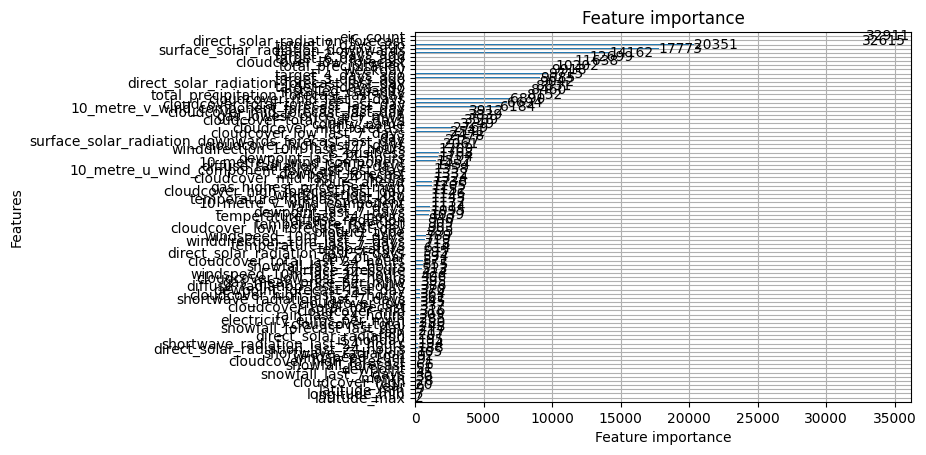

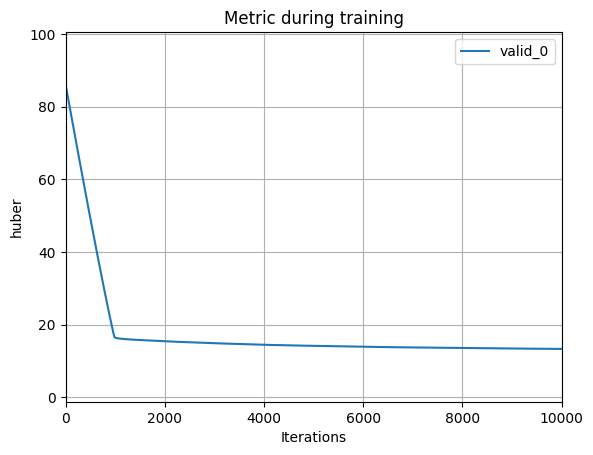

In [34]:
from typing import Generator

def cross_validation_month_and_year(dataframe: pd.DataFrame, datetime_col: str = "datetime", train_months: int = 3, test_months: int = 1) -> Generator:
    data_ = dataframe.copy(deep=True)
    data_["month_year"] = data_[datetime_col].dt.strftime('%Y-%m')
    unique_months = data_["month_year"].unique()
    unique_months.sort()
    for i, month_year in enumerate(unique_months[:-test_months], start=0):
        year, month = month_year.split("-")
        year, month = int(year), int(month)

        if data_.query("month == @month & year < @year").shape[0] == 0:
            continue
        
        if i < train_months:
            train_month_start, train_month_end = unique_months[0], unique_months[i]
        else:
            train_month_start, train_month_end = unique_months[i-train_months+1], unique_months[i]
        test_month_start, test_month_end = unique_months[i + 1], unique_months[i + test_months]

        train = data_[(data_["month_year"] >= train_month_start) & (data_["month_year"] <= train_month_end)]
        train_index = pd.concat([train, data_.query("month == @month & year < @year")]).index
        
        

        test_index = data_[(data_["month_year"] >= test_month_start) & (data_["month_year"] <= test_month_end)].index
        
        yield train_index, test_index, train_month_start, train_month_end, test_month_start, test_month_end


def cross_validation_month(dataframe: pd.DataFrame, datetime_col: str = "datetime", train_months: int = 3, test_months: int = 1) -> Generator:
    data_ = dataframe.copy(deep=True)
    data_["month_year"] = data_[datetime_col].dt.strftime('%Y-%m')
    unique_months = data_["month_year"].unique()
    unique_months.sort()
    for i, month_year in enumerate(unique_months[:-test_months], start=0):
        if i < train_months:
            train_month_start, train_month_end = unique_months[0], unique_months[i]
            continue
        else:
            train_month_start, train_month_end = unique_months[i-train_months+1], unique_months[i]
        test_month_start, test_month_end = unique_months[i + 1], unique_months[i + test_months]

        yield data_[(data_["month_year"] >= train_month_start) & (data_["month_year"] <= train_month_end)].index, data_[(data_["month_year"] >= test_month_start) & (data_["month_year"] <= test_month_end)].index, train_month_start, train_month_end, test_month_start, test_month_end

def cross_validation(dataframe: pd.DataFrame, datetime_col: str = "datetime", n_splits: int = 5) -> Generator:
    unique_datetimes = dataframe[datetime_col].unique()
    length_unique_datetimes = dataframe[datetime_col].unique().shape[0]
    test_size = length_unique_datetimes // (1+n_splits)
    print(f"unique datetimes n: {length_unique_datetimes} - test_size: {test_size} - splits: {n_splits}\n")
    for i in range(n_splits):
        train_start_index, train_end_index = 0, (i+1)*test_size
        test_start_index, test_end_index = train_end_index+1, train_end_index+1+test_size

        train_start, train_end = unique_datetimes[train_start_index], unique_datetimes[train_end_index]
        test_start, test_end = unique_datetimes[test_start_index], unique_datetimes[test_end_index] if test_end_index < length_unique_datetimes else unique_datetimes[-1]

        if test_end_index < length_unique_datetimes:
            yield dataframe[(dataframe[datetime_col] >= train_start) & (dataframe[datetime_col] <= train_end)].index, dataframe[(dataframe[datetime_col] >= test_start) & (dataframe[datetime_col] <= test_end)].index
        else:
            yield dataframe[(dataframe[datetime_col] >= train_start) & (dataframe[datetime_col] <= train_end)].index, dataframe[(dataframe[datetime_col] >= test_start)].index


def training_loop_no_mlflow(dataframe: pd.DataFrame):    
    models = {
        "consumer": [],
        "producer": []
    }
    for is_consumer in [0, 1]:
        client_type = "consumer" if is_consumer else "producer"
        print(f"Training for {client_type}")
        # tscv = TimeSeriesSplit()
        data = dataframe[dataframe.is_consumption == is_consumer].reset_index(drop=True).drop(columns=["is_consumption"]).copy(deep=True)
        # print(f"data.shape - {data.shape}")
        for i, (train_index, test_index, train_month_start, train_month_end, test_month_start, test_month_end) in enumerate(cross_validation_month_and_year(data, datetime_col="datetime", train_months=15, test_months=6)):
            print(f"Split {i+1} - train_month_start: {train_month_start} - train_month_end: {train_month_end} - test_month_start: {test_month_start} -  test_month_end: {test_month_end}")
            models[client_type].append(train_model(data, train_index, test_index))
            break
        break
    return models

models = training_loop_no_mlflow(dataframe=X)

In [35]:
feature_importances = pd.DataFrame({"feature": models.get("producer")[0].feature_name_, "importance": models.get("producer")[0].feature_importances_}).sort_values("importance", ascending=False)

In [37]:
feature_importances

,feature,importance
7,eic_count,32911
41,direct_solar_radiation_forecast,32615
88,target_7_days_ago,20351
42,surface_solar_radiation_downwards,17773
83,target_2_days_ago,14162
...,...,...
28,latitude_max,2
16,snowfall,0
89,quarter,0
30,longitude_max,0


In [36]:
noise_importance = feature_importances.query("feature == 'noise'").importance.item()
feature_importances[feature_importances["importance"] < noise_importance].feature.tolist()

[]

# Predict

In [ ]:
TEST_DATA_PATH: pathlib.Path = BASE_DATA_PATH / "example_test_files"

CLIENTS_TEST_PATH: pathlib.Path = TEST_DATA_PATH / 'client.csv'
ELECTRICITY_TEST_PATH: pathlib.Path = TEST_DATA_PATH / 'electricity_prices.csv'
GAS_TEST_PATH: pathlib.Path = TEST_DATA_PATH / 'gas_prices.csv'
HISTORICAL_TEST_WEATHER_PATH: pathlib.Path = TEST_DATA_PATH / 'historical_weather.csv'
WEATHER_FORECAST_TEST_PATH: pathlib.Path = TEST_DATA_PATH / 'forecast_weather.csv'
TRAIN_TEST_PATH: pathlib.Path = TEST_DATA_PATH / 'train.csv'
REVEALED_TARGET_PATH: pathlib.Path = TEST_DATA_PATH / "revealed_targets.csv"
SAMPLE_SUBMISSION_PATH: pathlib.Path = TEST_DATA_PATH / "sample_submission.csv"